### Things learnt here
- Working with messages (def msgs and invoking llm and then through graph)
- Reducer - add_messages, RemoveMessages.
- trim messages

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
#Defining some messages

from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content="Hello! So you wanted to know about the consequences of being apolitical?", name = "Bot")]
messages.append(HumanMessage(content="Yes! What was the need to establish a political structure?",name = "Junaid"))

for msg in messages:
    msg.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hello! So you wanted to know about the consequences of being apolitical?
================================ Human Message =================================
Name: Junaid

Yes! What was the need to establish a political structure?


In [14]:
#Invoking a chat model with these messages

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(name = "gpt-3.5-turbo")
llm.invoke(messages)

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


AIMessage(content='The establishment of a political structure serves several purposes. Here are some reasons for the need to establish a political structure:\n\n1. Governance: A political structure provides a framework for governance and decision-making in a society. It sets out the rules and procedures for how power is distributed and exercised, and how resources are allocated.\n\n2. Representation: Political structures allow for the representation of diverse interests and viewpoints within a society. Through elections and political processes, individuals can participate in decision-making and have their voices heard.\n\n3. Stability: A political structure helps to maintain stability and order within a society by providing a system for resolving conflicts and disputes. It establishes institutions and mechanisms for enforcing laws and promoting social cohesion.\n\n4. Accountability: Political structures help to hold those in power accountable for their actions and decisions. Through me

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


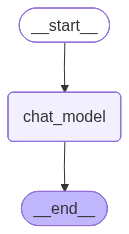

In [17]:
# Doing the same as above but with a graph

from IPython.display import Image, display
from langgraph.graph import StateGraph, MessagesState, START, END

def chat_model(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

builder = StateGraph(MessagesState)

builder.add_node("chat_model", chat_model)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
msg = graph.invoke({"messages":messages})
for m in msg["messages"]:
    m.pretty_print()

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Name: Bot

Hello! So you wanted to know about the consequences of being apolitical?
================================ Human Message =================================
Name: Junaid

Yes! What was the need to establish a political structure?
================================== Ai Message ==================================

The establishment of a political structure was crucial for several reasons. Firstly, it provides a framework for governance and decision-making, ensuring that there are mechanisms in place to address issues and manage societal affairs effectively. A political structure helps in organizing society, establishing laws and regulations, allocating resources, and providing security and stability.

Moreover, politics plays a critical role in representing the diverse interests and viewpoints within a society. Through political structures such as democratic institutions, people can participate in the 

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


- What happens when the chat/agent is long running. We need to get rid of some msgs-. We do that with RemoveMessages

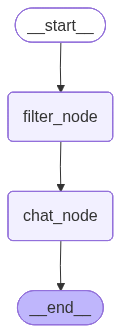

In [23]:
from langgraph.graph.message import RemoveMessage

def filter_node(state: MessagesState):
    return {"messages": [RemoveMessage(id = m.id) for m in state["messages"][:-2]] }

def chat_node(state:MessagesState):
    return {"messages" : llm.invoke(state["messages"])}

builder = StateGraph(MessagesState)

builder.add_node("filter_node",filter_node)
builder.add_node("chat_node", chat_node)

builder.add_edge(START, "filter_node")
builder.add_edge("filter_node", "chat_node")
builder.add_edge("chat_node", END)

ReducerGraph = builder.compile()

display(Image(ReducerGraph.get_graph().draw_mermaid_png()))

In [32]:
messages = [AIMessage(content="Hi", name = "Bot")]
messages.append(HumanMessage("content = ""Hello!", name = "Junaid"))
messages.append(AIMessage(content = "So you wanted to know the consequences of being apolitical", name = "Bot"))
messages.append(HumanMessage(content="Yes! And what was the basis of political structure?", name = "Junaid"))

In [33]:
output = ReducerGraph.invoke({"messages" : messages })
for out in output["messages"]:
    out.pretty_print()

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Name: Bot

So you wanted to know the consequences of being apolitical
================================ Human Message =================================
Name: Junaid

Yes! And what was the basis of political structure?
================================== Ai Message ==================================

The consequences of being apolitical include potentially being uninformed or unaware of important social issues and policies that affect you and your community, not participating in the democratic process by voting or engaging in civic activities, and not having a voice in shaping the future of your society. Being apolitical can also lead to a lack of representation and advocacy for your interests and values.

The basis of political structure varies depending on the form of government, but in general, it is founded on principles such as governance, power, authority, and the distribution of resources. Political st

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


- We can see above that the first two messages are not shown because filter (RemoveMessage) removed the two msgs

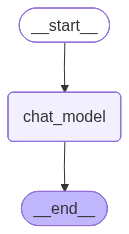

In [34]:
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"][-1:])}     #[-1:] - invoking llm on the last message

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
filtergraph = builder.compile()

# View
display(Image(filtergraph.get_graph().draw_mermaid_png()))

In [35]:
messages.append(output["messages"][-1])
messages.append(HumanMessage(content="Then tell me about the very first form of Government", name = "Junaid"))

In [42]:
output = filtergraph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Name: Bot

Hi
================================ Human Message =================================
Name: Junaid

content = Hello!
================================== Ai Message ==================================
Name: Bot

So you wanted to know the consequences of being apolitical
================================ Human Message =================================
Name: Junaid

Yes! And what was the basis of political structure?
================================== Ai Message ==================================

The consequences of being apolitical include potentially being uninformed or unaware of important social issues and policies that affect you and your community, not participating in the democratic process by voting or engaging in civic activities, and not having a voice in shaping the future of your society. Being apolitical can also lead to a lack of representation and advocacy for your interests and values.


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


### TRIMMING

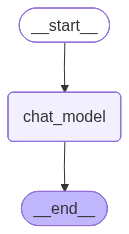

In [45]:
from langchain_core.messages import trim_messages

def chat_model_node(state: MessagesState):
    messages = trim_messages(messages=state["messages"], 
                             allow_partial=False, 
                             max_tokens=100,
                             strategy="last",
                             token_counter=ChatOpenAI(model="gpt-3.5-turbo"))
    return {"messages" : llm.invoke(messages)}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
trimGraph = builder.compile()

# View
display(Image(trimGraph.get_graph().draw_mermaid_png()))

In [46]:
messages.append(output["messages"][-1])
messages.append(HumanMessage(content = "So if tribal governments were the first ones, What was the role of woman participation?", name = "Junaid"))

In [48]:
output = trimGraph.invoke({"messages": messages})

for m in output["messages"]:
    m.pretty_print()

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================
Name: Bot

Hi
================================ Human Message =================================
Name: Junaid

content = Hello!
================================== Ai Message ==================================
Name: Bot

So you wanted to know the consequences of being apolitical
================================ Human Message =================================
Name: Junaid

Yes! And what was the basis of political structure?
================================== Ai Message ==================================

The consequences of being apolitical include potentially being uninformed or unaware of important social issues and policies that affect you and your community, not participating in the democratic process by voting or engaging in civic activities, and not having a voice in shaping the future of your society. Being apolitical can also lead to a lack of representation and advocacy for your interests and values.


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


In [ ]:
trim_messages(messages,
            allow_partial=False, 
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-3.5-turbo"))